In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def normalizedCrossCorrolation(true, pred):

    if np.isnan(true).any():
        true = true.reshape(-1,)
        pred = pred.reshape(-1,)
        mask = np.isnan(true)
        true = true[~mask]
        pred = pred[~mask]

    if true.shape != pred.shape:
        raise ValueError("The input arrays must have the same shape.")
    
    # Subtract the mean of each array to make them zero-mean
    true_mean_subtracted = true - np.mean(true)
    pred_mean_subtracted = pred - np.mean(pred)
    
    # Compute the cross-correlation term
    numerator = np.sum(true_mean_subtracted * pred_mean_subtracted)
    
    # Compute the normalization terms
    denominator = np.sqrt(np.sum(true_mean_subtracted ** 2)) * np.sqrt(np.sum(pred_mean_subtracted ** 2))
    
    # Compute the NCC
    ncc = numerator / denominator
    
    return ncc


def r2(true, pred):
    if np.isnan(true).any():
        true = true.reshape(-1,)
        pred = pred.reshape(-1,)
        mask = np.isnan(true)
        true = true[~mask]
        pred = pred[~mask]
        # true[mask] = 0
        # pred[mask] = 0
    ss_res = np.sum(np.power(true - pred, 2))
    ss_tot = np.sum(np.power(true - np.mean(true), 2))
    return 1 - ss_res / ss_tot

def NRMSE(true, pred):
    if np.isnan(true).any():
        true = true.reshape(-1,)
        pred = pred.reshape(-1,)
        mask = np.isnan(true)
        true = true[~mask]
        pred = pred[~mask]
    max_ = np.max(true)
    min_ = np.min(true)
    squaredError = np.sqrt(np.power((true - pred), 2))
    return np.mean(squaredError / (max_ - min_)) * 100
# def mape(true, pred):
#     return jnp.abs(true - pred).mean() / jnp.abs(true).mean() * 100


def rMSE(true, pred):
    if np.isnan(true).any():
        true = true.reshape(-1,)
        pred = pred.reshape(-1,)
        mask = np.isnan(true)
        true = true[~mask]
        pred = pred[~mask]
    return np.mean(np.power(true - pred, 2) / (.5 * (np.power(true, 2) + np.power(pred, 2)+1e-12))) * 100

def sMAPE(true, pred):
    if np.isnan(true).any():
        true = true.reshape(-1,)
        pred = pred.reshape(-1,)
        mask = np.isnan(true)
        true = true[~mask]
        pred = pred[~mask]
    diff = np.abs(true - pred)
    denom = ( np.abs(true) + np.abs(pred))
    re = (2*diff) / denom
    return np.nanmean(re) * 100
    # return np.nanmean(np.abs(true - pred) / (.5 * (np.abs(true) + np.abs(pred)))) * 100

def smape(A, B):
    """
    Calculate the symmetric mean absolute percentage error (sMAPE) between two 2D fields.
    It ignores the positions with NaN values.

    :param A: 2D array-like, the true values.
    :param B: 2D array-like, the predicted values.
    :return: sMAPE value.
    """
    A = np.array(A)
    B = np.array(B)

    # Ensure that A and B have the same shape
    if A.shape != B.shape:
        raise ValueError("The dimensions of A and B must be the same to compute sMAPE.")

    # Calculate sMAPE
    numerator = np.abs(A - B)
    denominator = (np.abs(A) + np.abs(B)) / 2.0

    # Ignore the NaN values
    valid_mask = ~np.isnan(numerator) & ~np.isnan(denominator) & (denominator != 0)
    
    numerator = numerator[valid_mask]
    denominator = denominator[valid_mask]

    # Handle the case where all values are NaN or denominator is zero
    if len(numerator) == 0 or len(denominator) == 0:
        return np.nan

    return 100 * np.mean(numerator / denominator)



In [4]:
log_list = ['/global/homes/y/yixuans/DeepAdjoint/checkpoints/2024-01-28_FNO-GM_D_AVG/logs/logs.pkl']
logs = []
for l in log_list:
    f = open(l, 'rb')
    logs.append(pickle.load(f))
    # train_log.keys()
    # print(np.array(train_log['train_metrics']).shape)


In [5]:
def plot_train(log_list, name):
    fig, ax = plt.subplots()
    # labels = ['ResNet', 'UNet', 'FNO']
    labels = ['FNO']
    color_cycle = ax._get_lines.prop_cycler
    if 'Loss' in name: 
        for i, log in enumerate(log_list):
            color = next(color_cycle)['color']
            ax.plot(log['train_loss'], color=color, label=f'{labels[i]} Train')
            ax.plot(log['val_loss'], '--', color=color, label=f'{labels[i]} Val')
    else:
        ax.plot(log['train_metrics'], label='Train')
        ax.plot(log['val_metrics'], label='Val')
    ax.set_box_aspect(1/1.62)
    ax.grid(linestyle='dotted')
    # ax.set_ylim(0,.5)
    ax.legend()
    ax.set_title(name)
    return fig

def plot_metrics(log):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    names = [r"$R^2$", "sMAPE", "rel-MSE"]
    tmetrics = np.array(log['train_metrics'])
    vmetrics = np.array(log['val_metrics'])
    for i, a in enumerate(ax):
        a.plot(tmetrics[:,i], label='Train')
        a.plot(vmetrics[:, i], label='Val')
        a.set_title(names[i])
        a.grid()
        a.set_box_aspect(1/1.62)
        a.legend()
    return fig

def plot_field(data):
    # data: 2D array
    fig, ax = plt.subplots()
    im=ax.imshow(data, cmap='seismic', aspect='auto', origin='lower')
    fig.colorbar(im)
    return fig

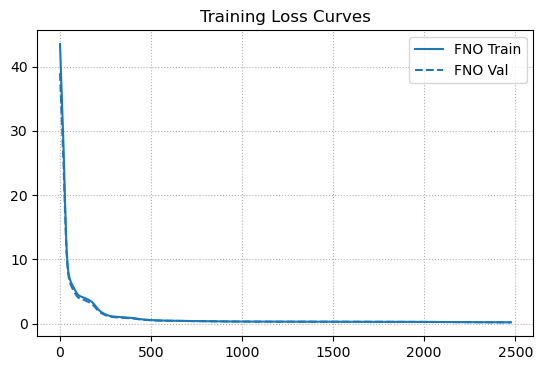

In [6]:
loss_plot = plot_train(logs, 'Training Loss Curves')
loss_plot.savefig('../eval_plots/train_curves_day_avg.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
with open('../tmp/SOMA_mask.pkl', 'rb') as f:
        mask = pickle.load(f)
        mask = np.logical_or(mask['mask1'], mask['mask2'])

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('Random gradient 2581', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%202581=11D2FF-164DF9-FF300B-FFBE06
    (0.000, (0.067, 0.824, 1.000)),
    (0.333, (0.086, 0.302, 0.976)),
    (0.667, (1.000, 0.188, 0.043)),
    (1.000, (1.000, 0.745, 0.024))))

def plot_field(true, pred, mask):
    '''field: shape [x, y]'''
    # param_t = true[..., 1][50, 50]
    # param_p = pred[..., 1][50, 50]

    true = true[..., 0]
    pred = pred[..., 0]


    mask_b = mask[0,0,:,:,0]
    # mask_b = np.broadcast_to(mask_b, true.shape)

    true[mask_b] = np.nan
    pred[mask_b] = np.nan

    vmin = np.nanmin(true)
    vmax = np.nanmax(true)
    diff = true - pred
    print(diff[~np.isnan(diff)])
    data = [true, pred, diff]
    titles = ['Predicted', 'True', 'Difference']
    fig, axs = plt.subplots(1,3, figsize=(13,8))
    for i, ax in enumerate(axs.ravel()):
        if i < 2:
            im = ax.imshow(data[i].T, 
                    cmap=cmap,
                    origin='lower',
                    aspect='auto',
                    vmin=vmin,
                    vmax=vmax)
        else:
            im = ax.imshow(data[i].T, 
                    cmap=cmap,
                    origin='lower',
                    aspect='auto',
                    vmin=-1,
                    vmax=1)
        ax.set_box_aspect(1)
        ax.set_title(titles[i], fontsize=16)
        ax.axis('off')
        cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=20)

   # plt.suptitle(f'Snapshot GM {param_t}, Avg GM {param_p}')
        
    plt.tight_layout()
    plt.show()
    return fig
    

DATA = 'GM_D_AVG'

# import h5py
# PATH='/pscratch/sd/y/yixuans/datatset/SOMA/'
# with h5py.File(PATH + 'thedataset-GM.hdf5' ,'r') as f:
#      data = f['forward_0'][20, 15, :, :, [10,16]]

# print(data.shape)

# with h5py.File(PATH + 'thedataset-GM-dayAvg-2.hdf5' ,'r') as f:
#      data_avg = f['forward_0'][20, 15, :, :, [8,16]]



with open(f'/pscratch/sd/y/yixuans/FNO-{DATA}-predictions.pkl', 'rb') as f:
    data = pickle.load(f)
true = data['true'][1]
pred = data['pred'][1]

true = np.transpose(true, axes=(0, 2, 3, 4, 1))
pred = np.transpose(pred, axes=(0, 2, 3, 4, 1))
t = true[3, 0,..., 3]
p = pred[3, 0, ..., 3]
print(r2(true[2, 0, ..., 3], pred[2, 0, ..., 3]), smape(true[2, 0, ..., 2], pred[2, 0, ...,2]))

fig = plot_field(t, p,  mask=mask)

0.9922671373933554 54.42255139350891


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [35]:
y = true[3, 0, ..., 3]
y_pred = pred[3, 0, ...,3]
print(y.shape, y_pred.shape)
print(sMAPE(y, y_pred ))
print(r2(y, y_pred))
print(NRMSE(y, y_pred))
print(normalizedCrossCorrolation(y, y_pred))

(100, 100) (100, 100)
3.771231323480606
0.19331973791122437
4.034204035997391
0.5180282


In [22]:
import h5py
f = h5py.File('/pscratch/sd/y/yixuans/datatset/SOMA/varyGM/PCA_data.h5', 'r')
data = f['PCA_data'][:]

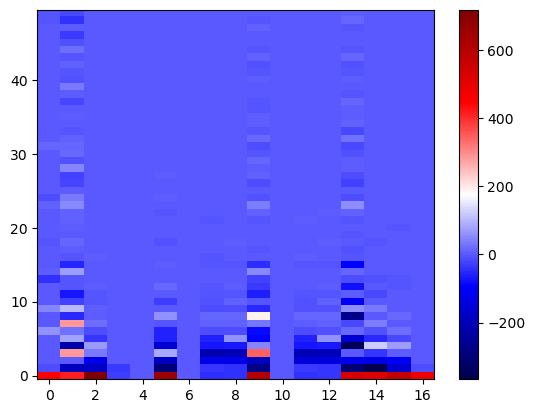

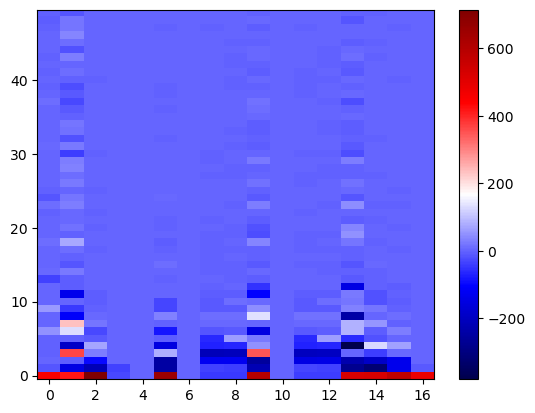

In [35]:
random_num = np.random.randint(data.shape[0])
field = plot_field(data[10])
field2 = plot_field(data[11])

In [14]:
# Making rollout animation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
from glob import glob
import os
import re
# Load the PNG images

image_files = sorted(glob('../eval_plots/rollout/Unet/01/temperature/*'), key=lambda x:float(re.findall("(t\d+)",x)[0][1:]))


# images = [imageio.imread(img_file) for img_file in image_files]

# import imageio

# # List of PNG image paths



images = [imageio.imread(image_file) for image_file in image_files]

output_file = 'Unet-temp-rollout.gif'
imageio.mimsave(output_file, images, duration=1)  # `duration` is the time for each frame in seconds



/tmp/ipykernel_1362711/3578840570.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(image_file) for image_file in image_files]


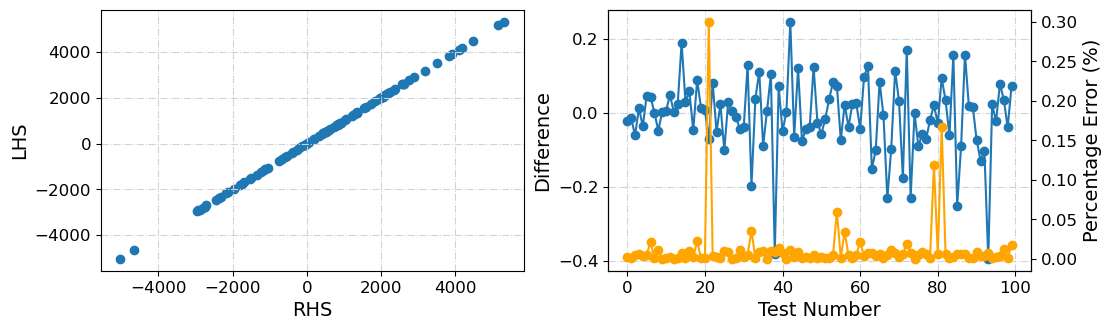

In [27]:
import pickle
with open('../tmp/dotTest.pkl', 'rb') as f:
    dotTest = pickle.load(f)

diff = np.array(dotTest['tangent']) - np.array(dotTest['adjoint'])
mape = np.abs(diff) / (0.5*(np.abs(dotTest['adjoint']) + np.abs(dotTest['tangent']))) * 100


plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax2 = ax[1].twinx()
for a in ax:
    a.set_box_aspect(1/1.62)

    a.grid(True, color='lightgray', linestyle='-.')
ax[0].scatter(dotTest['adjoint'], dotTest['tangent'])
ax[0].set_ylabel('LHS')
ax[0].set_xlabel('RHS')

ax[1].plot(np.arange(len(diff)), diff, marker='o')
ax[1].set_ylabel('Difference')
ax[1].set_xlabel("Test Number")

ax2.plot(np.arange(len(diff)), mape, marker='o', color='orange' )
ax2.set_ylabel('Percentage Error (%)')

fig.savefig('../eval_plots/dottest.pdf', format='pdf', bbox_inches='tight')